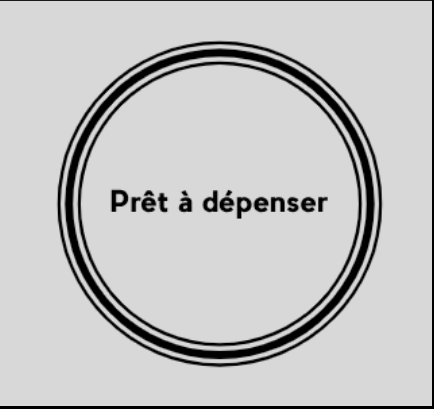

### Vous retrouverez toute ma méthodologie <a href="https://github.com/CLIRD/scoring-app/blob/main/Notes%20m%C3%A9thodologique_OCR.pdf">ici</a>


# <a name = "sommaire"> Sommaire 

- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#func"> Fonction globale </a>
- <a href ="#log"> Connexion et création d'une expérimentation avec MLflow sur databricks </a>
- <a href ="#pipe1"> Pipeline pour les modèles basés sur les arbres de décision </a>
- <a href ="#pipe2"> Pipeline pour les modèles linéaires</a>
- <a href ="#opt"> Optimisation des différents modèles: </a>
  - <a href ="#opt1"> RandomForest  </a>
  - <a href ="#opt2"> Régression logistic  </a>
  - <a href ="#opt3"> XGBoost </a>
- <a href ="#selec">Sélection du modèle final </a>
- <a href ="#opt4">Optimisation du seuil </a>
- <a href ="#opt5">Evidently </a>

# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
!pip install mlflow
!pip install evidently

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, fbeta_score, f1_score, make_scorer, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import pickle


from functools import partial

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import mlflow

from xgboost import XGBClassifier

set_config(display='diagram')

from evidently.report import Report
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.metric_preset import DataDriftPreset

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/y_test.csv')
data_prod = pd.read_csv('/content/drive/MyDrive/P7_modèle_de_scoring/data/data_prod.csv')

# <a name = "func"> Fonction globale</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
def objective(params, run_name, model_name, preprocessor, scoring, model, loss_func, maximize = True):

    """
    Entraîne un modèle d'apprentissage automatique en utilisant la validation croisée et enregistre les mesures d'évaluation dans MLflow.
    Args:
      params (dict) : Dictionnaire contenant les hyperparamètres.
      run_name (str) : Nom de l'exécution MLflow.
      model_name (str) : Nom du modèle.
      preprocessor (sklearn pipeline) : Pipeline Scikit-learn pour le prétraitement des données.
      scoring (dict) : Dictionnaire contenant les métriques.
      model : Classe du modèle à utiliser.
      loss_func (str) : Métrique d'évaluation utilisée pour calculer la fonction de perte.
      maximize (bool, facultatif) : Permet de maximiser ou de minimiser la fonction de perte. La valeur par défaut est True.
    Returns:
      dict : Dictionnaire contenant la valeur de la perte et l'état de l'optimisation pour la fonction de minimisation d'hyperopt.
      """
    with mlflow.start_run(run_name = run_name):
      mlflow.set_tag('model', model_name)
      mlflow.log_params(params)

      model_tune = model(**params)
      pipe = Pipeline([
          ('preprocessing', preprocessor),
          ('clf', model_tune )])
      
      cv_results = cross_validate(pipe, X_train, y_train.TARGET, cv=cv, scoring = scoring)

      accuracy = cv_results['test_accuracy'].mean()
      precision = cv_results['test_precision'].mean()
      recall = cv_results['test_recall'].mean()
      custom_metric = cv_results['test_custom_metrics'].mean()
      fbeta_score = cv_results['test_fbeta_score'].mean()
      auc = cv_results['test_auc'].mean()
      f1_score = cv_results['test_f1_score'].mean()

      mlflow.log_metric('auc', auc)
      mlflow.log_metric('accuracy', accuracy)
      mlflow.log_metric('precision', precision)
      mlflow.log_metric('recall', recall)
      mlflow.log_metric('custom_metric', custom_metric)
      mlflow.log_metric('fbeta_score', fbeta_score)
      mlflow.log_metric('f1_score', f1_score)

      metrics = {'auc': auc,
                  'accuracy': accuracy,
                  'precision': precision,
                  'recall': recall,
                  'custom_metric': custom_metric,
                  'fbeta_score': fbeta_score,
                  'f1_score':f1_score}
      if maximize:
        return {'loss': 1 - metrics[loss_func], 'status': STATUS_OK}
      else: return {'loss': metrics[loss_func], 'status': STATUS_OK}


def optimize_log_reg(loss_func, scoring, params, run_name, model_name):
  """
  Optimise un modèle de régression logistique en ajustant ses hyperparamètres à l'aide de GridSearchCV et enregistre les mesures d'évaluation dans MLflow.
  Args:
    loss_func (str) : Métrique d'évaluation utilisée pour calculer la fonction de perte.
    scoring (dict) : Dictionnaire contenant les métriques.
    params (dict) : Dictionnaire contenant les hyperparamètres pour ajuster le modèle.
    run_name (str) : Nom de l'exécution MLflow.
    model_name (str) : Nom du modèle.
  Returns:
    None
  """
  reg_log = LogisticRegression(random_state = 0, class_weight = 'balanced', solver = 'saga', max_iter = 10_000)
  complete_pipe = make_pipeline(preprocessor_bas, reg_log)

  clf = GridSearchCV(complete_pipe, param_grid = params, cv = cv, scoring = scoring_lr, refit = loss_func)
  clf.fit(X_train, y_train.TARGET)

  for i, params in enumerate(clf.cv_results_['params']):
      with mlflow.start_run(run_name = run_name, nested = True):
        mlflow.set_tag('model', model_name)
        mlflow.log_param('C', params['logisticregression__C'])
        mlflow.log_param('penalty', params['logisticregression__penalty'])
        accuracy = clf.cv_results_['mean_test_accuracy'][i]
        precision = clf.cv_results_['mean_test_precision'][i]
        recall = clf.cv_results_['mean_test_recall'][i]
        custom_metric = clf.cv_results_['mean_test_custom_metrics'][i]
        fbeta_score = clf.cv_results_['mean_test_fbeta_score'][i]
        auc = clf.cv_results_['mean_test_auc'][i]
        f1_score = clf.cv_results_['mean_test_f1_score'][i]
        duration = clf.cv_results_['mean_fit_time'][i]

        mlflow.log_metric('auc', auc)
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('custom_metric', custom_metric)
        mlflow.log_metric('fbeta_score', fbeta_score)
        mlflow.log_metric('f1_score', f1_score)
        mlflow.log_metric('duration', duration)

# <a name = "log"> Connexion et création d'une expérimentation avec MLflow sur databricks</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/680mt1xll@mozmail.com/scoring")

# <a name = "pipe1"> Pipeline pour les modèles basés sur les arbres de décision</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
      X = X.replace([np.inf, -np.inf], np.nan)
      return X.values

In [ ]:
columns_na = ['OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE']
numerical_col = X_train.select_dtypes(include = np.number).columns
categorical_col = X_train.select_dtypes(exclude = np.number).columns
freq_columns = [i for i in categorical_col if i not in columns_na]
na_columns = [i for i in categorical_col if i in columns_na]

In [ ]:
onehot_transformer = OneHotEncoder(handle_unknown = 'ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
scaler = RobustScaler()

simpleimputer_frequency = SimpleImputer(strategy = "most_frequent")
simpleimputer_constant = SimpleImputer(strategy = "constant", fill_value = "XNA")
simpleimputer_median = SimpleImputer(strategy = "median")

In [ ]:
pipeline_const_dt = make_pipeline(simpleimputer_constant, ordinal_transformer)
pipeline_most_frequente_dt = make_pipeline(simpleimputer_frequency, ordinal_transformer)
pipeline_mediane_scaler_dt = make_pipeline(NumericalTransformer(),simpleimputer_median, scaler)

In [ ]:
preprocessor_dt = ColumnTransformer(
    transformers=[
        ('constant_columns', pipeline_const_dt, na_columns),
        ('most_frequent_columns', pipeline_most_frequente_dt, freq_columns),
        ('nums_columns', pipeline_mediane_scaler_dt, numerical_col),
    ])
preprocessor_dt

ColumnTransformer(transformers=[('constant_columns',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='XNA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['OCCUPATION_TYPE', 'HOUSETYPE_MODE',
                                  'EMERGENCYSTATE_MODE']),
                                ('most_frequent_columns',
                                 Pipeline(steps=[('simpleimputer',
                                                  Simpl...
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       ...
       'APPROVED_DAYS_DECISION_MEAN', 'APPROVED_CNT_PAYMENT_MEAN',
       'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_COUNT',
       'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'INSTAL_COUNT'],
      dtype='object', length=147))])

# <a name = "pipe2"> Pipeline pour les modèles linéaires</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
ord_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']
one_hot_columns = [i for i in categorical_col if i not in ord_columns]
one_hot_columns_frequency = [i for i in one_hot_columns if i not in na_columns]

In [ ]:
pipeline_frequency_one_hot = make_pipeline(simpleimputer_frequency, onehot_transformer)
pipeline_const_one_hot = make_pipeline(simpleimputer_constant, onehot_transformer)
pipeline_frequency_ord = make_pipeline(simpleimputer_frequency, ordinal_transformer)

In [ ]:
preprocessor_bas = ColumnTransformer(
    transformers=[
        ('ordinal_with_frequency', pipeline_frequency_ord, ord_columns),
        ('constant_with_one_hot', pipeline_const_one_hot, columns_na),
        ('frequency_with_one_hot', pipeline_frequency_one_hot, one_hot_columns_frequency),
        ('nums_columns', pipeline_mediane_scaler_dt, numerical_col),
    ])
preprocessor_bas

ColumnTransformer(transformers=[('ordinal_with_frequency',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']),
                                ('constant_with_one_hot',
                                 Pipeline(steps=[('simpleimputer'...
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       ...
       'APPROVED_DAYS_DECISION_MEAN', 'APPROVED_CNT_PAYMENT_MEAN',
       'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_COUNT',
       'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'INSTAL_COUNT'],
      dtype='object', length=147))])

# <a name = "opt"> Optimisation des différents modèles</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "opt1"> RandomForest</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour ce premier modèle, on va utiliser le RandomForest qui a pour but d'utiliser plusieurs arbres de décision et utiliser la théorie de l'ensemble learning afin de faire fonctionner ces arbres ensembles, c'est-à-dire que la prédiction sera ici la classe majoritaire de tous les arbres.

Pour la recherche des hyperparametres on va utiliser hyperopt qui va permettre de trouver les meilleurs hyperparamètres pour un modèle en explorant de manière intelligente l'espace des hyperparamètres à l'aide de l'optimisation bayésienne.

On va faire une recherche d'hyperparamètres pour les paramètres n_estimators, max_depth et min_samples_split qui vont permettre de gérer la précision du modèle ainsi que sa complexité et sa capacité à se géneraliser. Concernant l'espace de recherche on va ici utiliser un espace assez restreint pour ce projet qu'on pourra affiner suivant les résultats pour trouver les hyperparamètres optimaux.

In [ ]:
cv = StratifiedKFold(n_splits=3)

In [ ]:
#cross_val_score(pipe, X_train, y_train, cv = 3, n_jobs = -1, scoring = 'roc_auc',  error_score="raise")

In [ ]:
def cost_function(y, y_pred, cost): 

  Conf= confusion_matrix(y, y_pred) 

  tn, fp, fn, tp = Conf[0,0], Conf[0,1], Conf[1,0], Conf[1,1] 

  return (cost * fn + fp) / (tn + cost * fn + fp + tp)

In [ ]:
scoring = {'accuracy':'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'custom_metrics': make_scorer(cost_function, cost = 10),
           'fbeta_score': make_scorer(fbeta_score, beta = 2),
           'auc': 'roc_auc',
           'f1_score': 'f1'}


In [ ]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = np.arange(3, 11, 1)
min_samples_split = np.arange(0.1 ,0.7, 0.15)

In [ ]:
search_space = {
    'max_depth': hp.choice('max_depth', max_depth),
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'min_samples_split': hp.choice('min_samples_split' ,min_samples_split),
    'class_weight': 'balanced',
    'random_state': 0
}

AUC

In [ ]:
fmin_objective = partial(objective, run_name='random_forest_auc_opt', model_name = 'random_forest_', preprocessor = preprocessor_dt, scoring = scoring,  model = RandomForestClassifier, loss_func = 'auc')

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

100%|██████████| 50/50 [1:29:57<00:00, 107.95s/it, best loss: 0.2605950950825777]


fbeta_score

In [ ]:
fmin_objective = partial(objective, run_name='random_forest_fbeta_score_opt', model_name = 'random_forest_', preprocessor = preprocessor_dt, scoring = scoring,  model = RandomForestClassifier, loss_func = 'fbeta_score')

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

100%|██████████| 50/50 [1:29:56<00:00, 107.93s/it, best loss: 0.8158159767681612]


custom_metric

In [ ]:
fmin_objective = partial(objective, run_name='random_forest_custom_score_opt', model_name = 'random_forest_', preprocessor = preprocessor_dt, scoring = scoring,  model = RandomForestClassifier, loss_func = 'custom_metric', maximize = False)

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

100%|██████████| 50/50 [1:34:25<00:00, 113.30s/it, best loss: 0.8079828183978145]


### <a name = "opt2"> Regression logistique </a> <a href ="#sommaire"> Retour au sommaire</a>

Nous allons utiliser la régression logistique pour notre deuxième modèle de classification. Son principe consiste à trouver une relation entre la variable binaire à prédire et les variables explicatives. Cette relation sera ensuite utilisée pour prédire la probabilité d'appartenance à une classe, à l'aide de la fonction sigmoïde.

Nous effectuerons une recherche d'hyperparamètres pour les paramètres "penalty" et "C", qui permettent de gérer la complexité du modèle et d'éviter le surajustement.

Au vu du temps d'excécution très long cette partie sera ignorer pour la suite

In [ ]:
scoring_lr = {'accuracy':'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'custom_metrics': make_scorer(cost_function, cost = 10, greater_is_better = False),
           'fbeta_score': make_scorer(fbeta_score, beta = 2),
           'auc': 'roc_auc',
           'f1_score': 'f1'}


In [ ]:
params_grid = {'logisticregression__penalty': ['l1', 'l2'],
               'logisticregression__C': [0.001, 0.1, 1, 10, 100]}

AUC

In [ ]:
optimize_log_reg(loss_func = 'auc', scoring = scoring, run_name = 'log_reg_auc', model_name = 'log_reg', params = params_grid)

fbeta_score

In [ ]:
optimize_log_reg(loss_func = 'fbeta_score', scoring = scoring, run_name = 'log_reg_fbeta', model_name = 'log_reg', params = params_grid)

custom_func

In [ ]:
optimize_log_reg(loss_func = 'custom_metrics', scoring = scoring, run_name = 'log_reg_custom_metric', model_name = 'log_reg', params = params_grid)

### <a name = "opt2"> XGBoost </a> <a href ="#sommaire"> Retour au sommaire</a>

Pour notre dernier modèle de classification on va utiliser le XGBoost qui est basé sur l'algorithme de gradient boosting qui va permettre d'améliorer les prédictions en corrigeant les erreurs commises par les modèles précédents.

On va également faire une recherche d'hyperparametres sur les parametres n_estimators, max_depth, min_child_weight, gamma, subsamples, colsample_bytree, reg_alpha, reg_lambda, learning_rate, scale_pos_weight qui vont permettre de gérer la complexité du modèle, de gérer le sur-ajustement du modèle ainsi que le déséquilibre de classe.

In [ ]:
weight = y_train.TARGET.value_counts()[0] / y_train.TARGET.value_counts()[1] 
weight

11.50677874186551

In [ ]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = np.arange(3, 11, 1)
min_child_weight = np.arange(1, 7, 1)
gamma = [i/10.0 for i in range(0,5)]
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]
reg_alpha = [0.001, 0.1, 1, 10, 100]
reg_lambda = [0.001, 0.1, 1, 10, 100]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
scale_pos_weight = [1, 5, 11, 15, 20, 25]

search_space_xgb = {
    'max_depth': hp.choice('max_depth', max_depth),
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'min_child_weight': hp.choice('min_child_weight' ,min_child_weight),
    'gamma': hp.choice('gamma', gamma),
    'subsample': hp.choice('subsample', subsample),
    'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree),
    'reg_alpha': hp.choice('reg_alpha', reg_alpha),
    'reg_lambda': hp.choice('reg_lambda', reg_lambda),
    'learning_rate': hp.choice('learning_rate', learning_rate),
    'scale_pos_weight': hp.choice('scale_pos_weight', scale_pos_weight),
    'seed': 0,
    #'tree_method': 'hist'
}

Auc

In [ ]:
fmin_objective = partial(objective, run_name='xgboost_auc_opt', model_name = 'xgboost', preprocessor = preprocessor_dt, scoring = scoring,  model = XGBClassifier, loss_func = 'auc')

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space_xgb, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

 16%|█▌        | 8/50 [29:10<2:39:10, 227.39s/it, best loss: 0.24304793066799535]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 34%|███▍      | 17/50 [1:44:58<3:26:13, 374.95s/it, best loss: 0.2414472898655693]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 88%|████████▊ | 44/50 [3:52:20<19:02, 190.44s/it, best loss: 0.2316786693328129]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 92%|█████████▏| 46/50 [4:03:02<16:31, 247.87s/it, best loss: 0.2316786693328129]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 98%|█████████▊| 49/50 [4:22:42<05:03, 303.51s/it, best loss: 0.2316786693328129]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [4:23:28<00:00, 316.16s/it, best loss: 0.2316786693328129]


fbeta_score

In [ ]:
fmin_objective = partial(objective, run_name='xgboost_fbeta_score_opt', model_name = 'xgboost', preprocessor = preprocessor_dt, scoring = scoring,  model = XGBClassifier, loss_func = 'fbeta_score')

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space_xgb, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

 16%|█▌        | 8/50 [28:55<2:39:30, 227.88s/it, best loss: 0.7341545124060693]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 34%|███▍      | 17/50 [1:48:13<3:36:20, 393.36s/it, best loss: 0.7292413047954724]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 74%|███████▍  | 37/50 [4:45:45<2:10:53, 604.11s/it, best loss: 0.7045709848998527]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 88%|████████▊ | 44/50 [5:47:58<47:42, 477.04s/it, best loss: 0.7045709848998527]  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [6:28:48<00:00, 466.57s/it, best loss: 0.7045709848998527]


custom_metric 

In [ ]:
fmin_objective = partial(objective, run_name='xgboost_custom_metrics_opt', model_name = 'xgboost', preprocessor = preprocessor_dt, scoring = scoring,  model = XGBClassifier, loss_func = 'custom_metric', maximize = False)

best_result_rf = fmin(
    fn = fmin_objective,
    space = search_space_xgb, 
    algo = tpe.suggest, 
    max_evals = 50,
    trials = Trials(),
    rstate = np.random.RandomState(0) 
)

 16%|█▌        | 8/50 [28:01<2:32:53, 218.41s/it, best loss: 0.2289683090327076]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 34%|███▍      | 17/50 [1:41:44<3:20:50, 365.18s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 52%|█████▏    | 26/50 [3:22:24<5:07:19, 768.33s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 54%|█████▍    | 27/50 [3:30:43<4:23:33, 687.53s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 56%|█████▌    | 28/50 [3:36:17<3:33:12, 581.47s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 62%|██████▏   | 31/50 [4:20:39<4:06:18, 777.79s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 76%|███████▌  | 38/50 [5:10:25<1:29:35, 447.97s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 88%|████████▊ | 44/50 [5:57:51<1:05:12, 652.10s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 90%|█████████ | 45/50 [6:02:36<45:10, 542.05s/it, best loss: 0.07995663956639566]  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 96%|█████████▌| 48/50 [6:23:06<15:26, 463.46s/it, best loss: 0.07995663956639566]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [6:37:35<00:00, 477.11s/it, best loss: 0.07995663956639566]


# <a name = "selec"> Sélection du modèle final</a> <a href ="#sommaire"> Retour au sommaire</a>

Comme expliqué dans la note méthodologique, pour le choix du modèle final on va procéder de la manière suivante:
- Nous allons sélectionné le meilleur modèle en fonction de la métrique optimisée, de sa performance globale et de son temps d'exécution sur la partie validation croisée à l'aide de MLflow.
- Nous aurons ensuite cinq modèles finaux que nous testerons sur le jeu de test pour vérifier leur capacité à généraliser. Nous choisirons alors le modèle final en fonction de sa performance globale sur le jeu de test.

In [ ]:
xgboost_auc = {'colsample_bytree':	0.6,
                'gamma':	0.0,
                'learning_rate':	0.1,
                'max_depth':	4,
                'min_child_weight':	2,
                'n_estimators':	300,
                'reg_alpha':	100,
                'reg_lambda':	0.1,
                'scale_pos_weight':	5,
                'seed':	0,
                'subsample':	0.8}

xgboost_fbeta = {'colsample_bytree':	0.6,
                'gamma':	0.0,
                'learning_rate':	0.01,
                'max_depth':	8,
                'min_child_weight':	6,
                'n_estimators':	500,
                'reg_alpha':	10,
                'reg_lambda':	100,
                'scale_pos_weight':	5,
                'seed':	0,
                'subsample':	0.9}

In [ ]:
model_rf_auc = RandomForestClassifier(max_depth = 9, n_estimators = 300, min_samples_split = 0.1, random_state = 0, class_weight = 'balanced')
model_rf_fbeta = RandomForestClassifier(max_depth = 7, n_estimators = 100, min_samples_split = 0.1, random_state = 0, class_weight = 'balanced')
model_rf_custom_metric = RandomForestClassifier(max_depth = 8, n_estimators = 300, min_samples_split = 0.1, random_state = 0, class_weight = 'balanced')

model_xgboost_auc = XGBClassifier(**xgboost_auc)
model_xgboost_fbeta = XGBClassifier(**xgboost_fbeta)

In [ ]:
mlflow.set_experiment("/Users/680mt1xll@mozmail.com/scoring_optimal")

In [ ]:
def final_model(model, run_name):
  with mlflow.start_run(run_name = run_name):
    pipeline = make_pipeline(preprocessor_dt, model)
    pipeline.fit(X_train, y_train.TARGET)

    y_pred = pipeline.predict(X_test)

    auc = roc_auc_score( y_test.TARGET ,pipeline.predict_proba(X_test)[:, 1])
    accuracy = accuracy_score( y_test.TARGET ,y_pred)
    recall =  recall_score( y_test.TARGET ,y_pred)
    precision = precision_score( y_test.TARGET ,y_pred)
    beta_score = fbeta_score( y_test.TARGET , y_pred, beta = 2)
    f1 = f1_score(y_test.TARGET, y_pred)
    custom_cost = cost_function(y_test.TARGET, y_pred, cost = 10)

    mlflow.log_metric('auc', auc)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('custom_metric', custom_cost)
    mlflow.log_metric('fbeta_score', beta_score)
    mlflow.log_metric('f1_score', f1)

In [ ]:
#------------------RF-AUC---------------
final_model(model_rf_auc, 'model_rf_auc')
#------------------RF-Fbeta---------------
final_model(model_rf_fbeta, 'model_rf_fbeta')
#------------------RF-Custom---------------
final_model(model_rf_custom_metric, 'model_rf_custom_metric')
#------------------XGBOOST-AUC---------------
final_model(model_xgboost_auc, 'model_xgboost_auc')
#------------------XGBOOST-Fbeta---------------
final_model(model_xgboost_fbeta, 'model_xgboost_fbeta')

### <a name = "opt4"> Optimisation du seuil</a> <a href ="#sommaire"> Retour au sommaire</a>

Afin d'optimiser notre modèle, nous allons chercher à déterminer le seuil idéal en utilisant trois métriques : l'aire sous la courbe ROC (AUC), le score fbeta et notre propre métrique métier. Une fois que nous avons obtenu le seuil optimal, nous allons comparer la performance globale de notre modèle avec ce seuil sur le jeu de test en utilisant le seuil par défaut comme référence. L'objectif est d'obtenir les meilleures performances possibles pour notre modèle.

In [ ]:
final_pipeline = make_pipeline(preprocessor_dt, model_xgboost_auc)
final_pipeline.fit(X_train, y_train.TARGET)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('constant_columns',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='XNA',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['OCCUPATION_TYPE',
                                                   'HOUSETYPE_MODE',
                                                   'EMERGENCYSTATE_MODE']),
                                                 ('most_frequent_columns',
                                                  P...
       'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_COUNT',
       'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'INSTAL_COUNT'],
      dtype='object', length=147))])),
                ('xgbclassifier',
                 XGBClassifier(colsample_bytree=0.6, gamma=0.0, max_depth=4,
                               min_child_weight=2, n_estimators=300,
                               reg_alpha=100, reg_lambda=0.1,
                               scale_pos_weight=5, seed=0, subsample=0.8))])

#### Performance avec seuil par défaut

In [ ]:
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

def predict_optimal_treshold(tr):

   probs_test = final_pipeline.predict_proba(X_test)[:, 1]
   prediction = [1 if i >= tr else 0 for i in probs_test]
   return prediction

def plot_metrics_and_cm(prediction):
  accuracy = accuracy_score( y_test.TARGET ,prediction)
  recall =  recall_score( y_test.TARGET ,prediction)
  precision = precision_score( y_test.TARGET ,prediction)
  beta_score = fbeta_score( y_test.TARGET , prediction, beta = 2)
  f1 = f1_score(y_test.TARGET, prediction)
  custom_cost = cost_function(y_test.TARGET, prediction, cost = 10)

  metrics_df = pd.DataFrame({'metrics': ['accuracy', 'recall', 'precision', 'beta_score', 'f1', 'custom_cost'], 
                             'scores': [accuracy, recall, precision, beta_score, f1, custom_cost]})
  plt.figure(figsize = (15, 10))
  sns.barplot(y = 'metrics', x = 'scores', data = metrics_df.sort_values('scores'), palette = 'PuBu')

  cm = confusion_matrix(y_test, prediction )
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

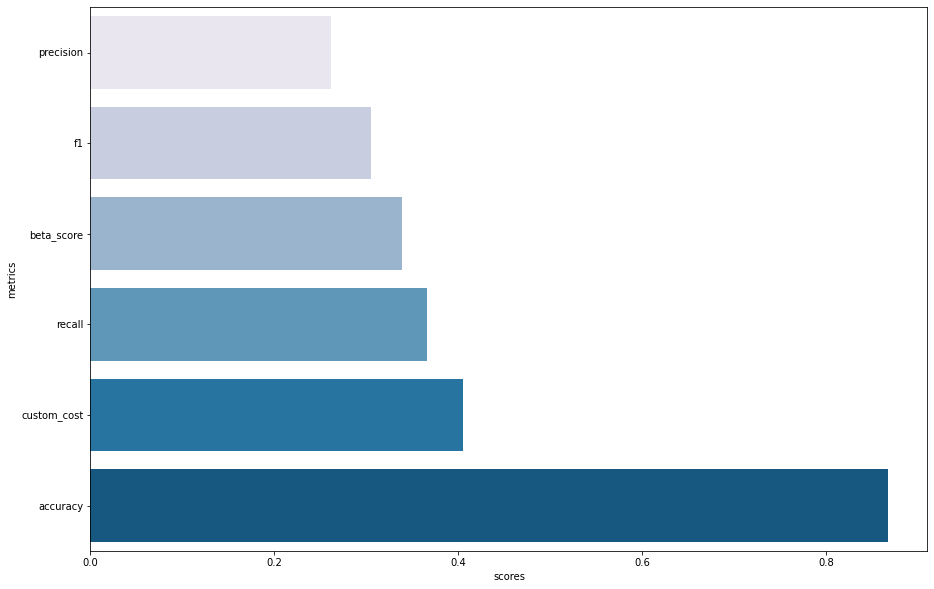

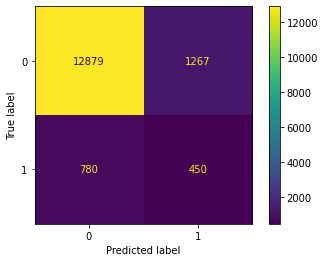

In [ ]:
plot_metrics_and_cm(final_pipeline.predict(X_test))

#### Optimisation du seuil en fonction du fbeta_score

In [ ]:
threshold = np.arange(0.05, 1.05, 0.05)
y_pred_probs = final_pipeline.predict_proba(X_train) 
probs = y_pred_probs[:, 1]
scores = [fbeta_score(y_train, to_labels(probs, t), beta = 2) for t in threshold]

ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))

Threshold=0.350, F-Score=0.51184


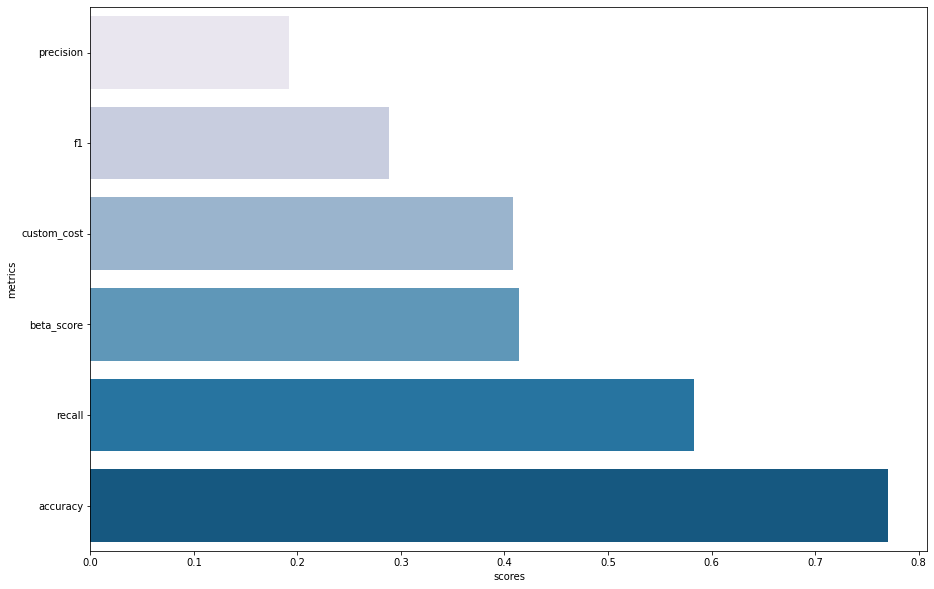

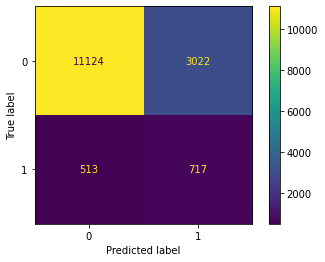

In [ ]:
fbeta_predictions = predict_optimal_treshold(tr = 0.35)
plot_metrics_and_cm(fbeta_predictions)

#### Optimisation du seuil en fonction de l'AUC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, probs)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.297211


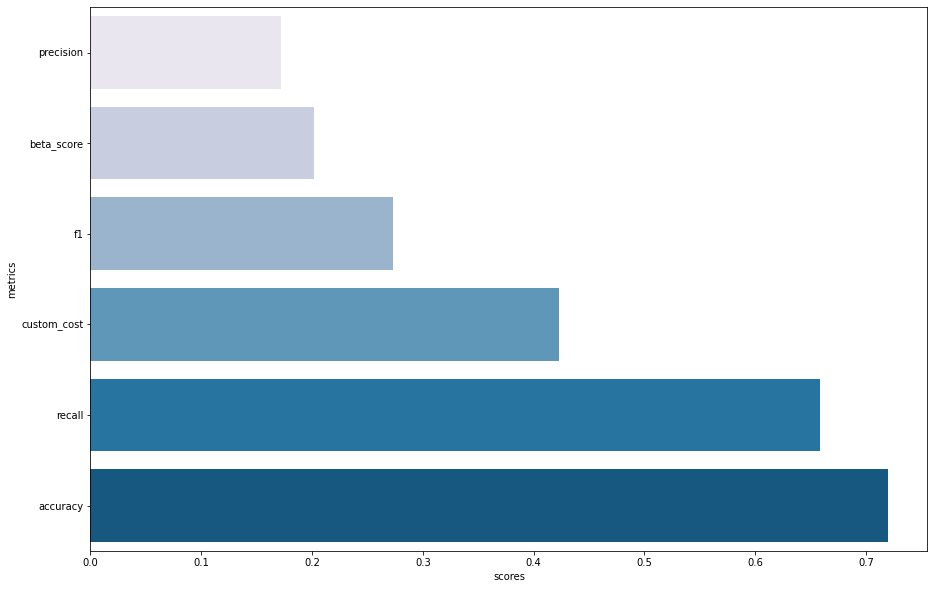

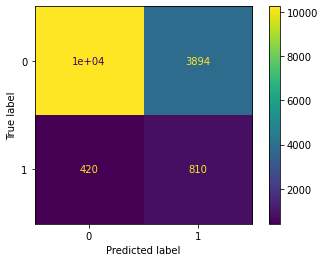

In [ ]:
roc_prediction = predict_optimal_treshold(tr = best_thresh)
plot_metrics_and_cm(roc_prediction)

#### Optimisation du seuil en fonction de la métrique métier

In [ ]:
scores = [cost_function(y_train, to_labels(probs, t), cost = 10) for t in threshold]
ix = np.argmin(scores)
print('Threshold=%.3f, F-Score=%.5f' % (threshold[ix], scores[ix]))

Threshold=0.400, F-Score=0.33595


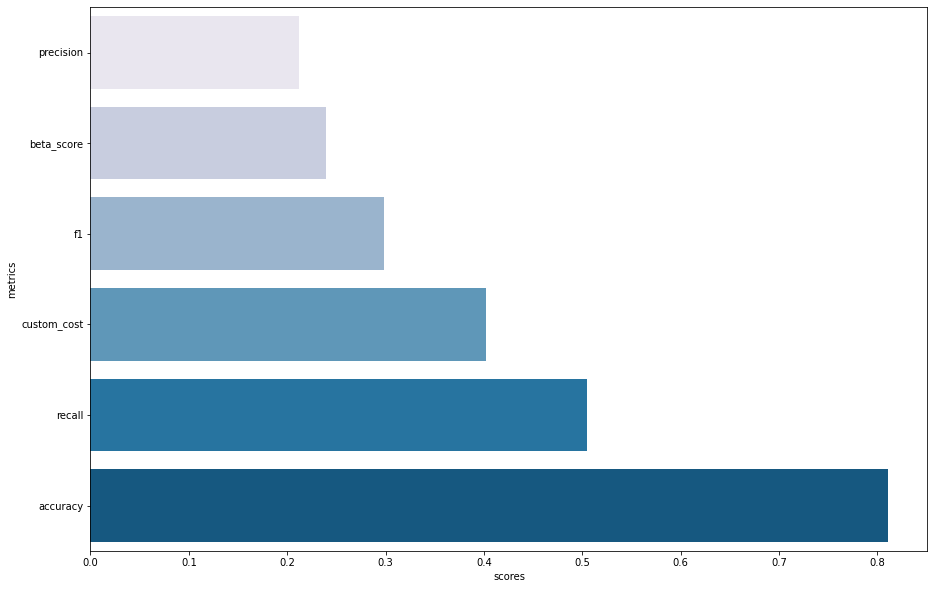

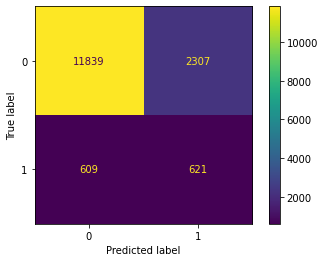

In [ ]:
custom_predictions = predict_optimal_treshold(tr = 0.4)
plot_metrics_and_cm(custom_predictions)

Ici on observant les différents résultats, on peut voir que l'optimisation du seuil avec le fbeta_score offre la meilleure performance globale. On peut donc conclure que les clients qui ont une probabilité de ne pas rembourser le prêt supérieure ou égale à 35% se verront refuser le prêt.

# <a name = "opt5"> Evidently </a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
importants_features = na_columns + freq_columns + numerical_col.tolist()
current_data = data_prod[importants_features]

In [ ]:
reference_data = X_train[importants_features]
#reference_data['TARGET'] = y_train.TARGET.values

In [ ]:
column_mapping = ColumnMapping()

In [ ]:
column_mapping.categorical_features = reference_data.select_dtypes(exclude=np.number).columns.tolist()
column_mapping.numerical_features = numerical_col.tolist()

In [ ]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(reference_data=reference_data, current_data=current_data,  column_mapping=column_mapping)
data_drift_report

In [ ]:
data_drift_report.save_html("data_drift_scoring_app.html")